In [2]:
#!/usr/bin/env python3
#in this script we will extract and downsample the SP T cells in the panfetal atlas dataset

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

In [3]:
adata = ad.read_h5ad("/g/data/yr31/hb1618/iPSC_project/datasets/panfetal_whole/panfetal_whole.h5ad")

In [4]:
print(adata)

AnnData object with n_obs × n_vars = 911873 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'


In [5]:
#first we will subset out the cell type of interest
cell_types_to_keep = ["MONOCYTE_II_CCR2"]
adata = adata[adata.obs['celltype_annotation'].isin(cell_types_to_keep)].copy() 

In [6]:
print(adata)

AnnData object with n_obs × n_vars = 10660 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'


In [7]:
#examine the donor metadata
adata.obs["donor"]

FCAImmP7579224-ACGGCCACAAGCTGAG    F45
FCAImmP7579224-CCGGGATGTCGCGGTT    F45
FCAImmP7579224-TGGTTAGAGCCCAACC    F45
FCAImmP7579224-GGGAGATCAGATAATG    F45
FCAImmP7579224-ACGAGGAAGGCTAGGT    F45
                                  ... 
FCAImmP7803020-CACAGTAAGGGATGGG    F50
FCAImmP7803020-CAGCTGGAGCTCCCAG    F50
FCAImmP7803020-GAATGAAGTGGGTATG    F50
FCAImmP7803020-GATGAGGAGGACGAAA    F50
FCAImmP7803020-TCTTTCCAGCAGGCTA    F50
Name: donor, Length: 10660, dtype: category
Categories (24, object): ['F21', 'F22', 'F23', 'F29', ..., 'F71', 'F72', 'F73', 'F78']

In [8]:
#performing quality control
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [9]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

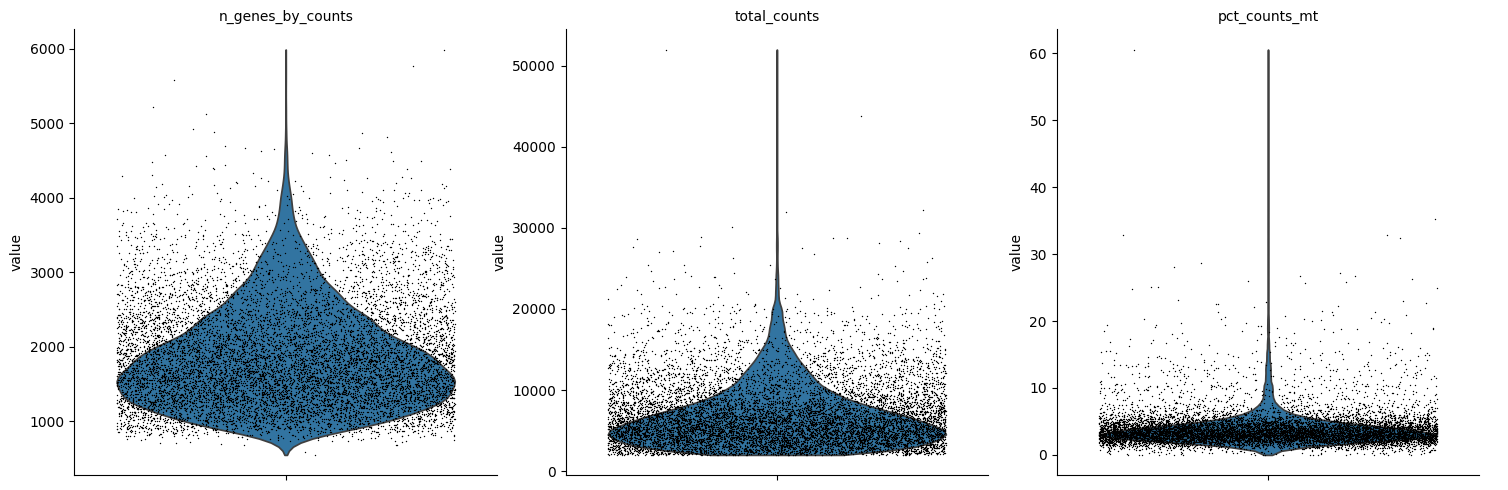

In [10]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

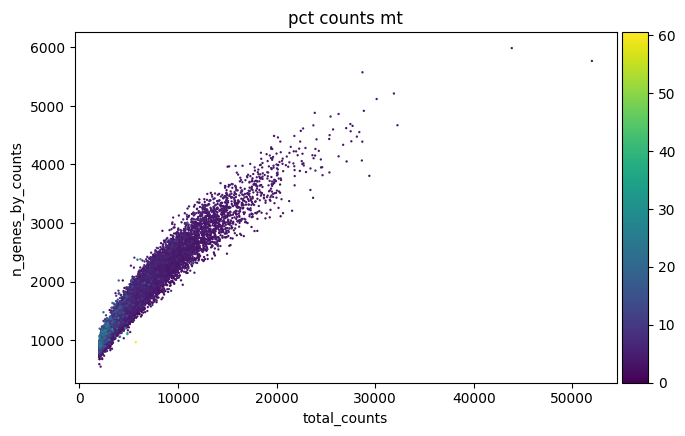

In [11]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [12]:
#it seems that QC has already been applied to the above cells
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs['pct_counts_mt'] < 10].copy()

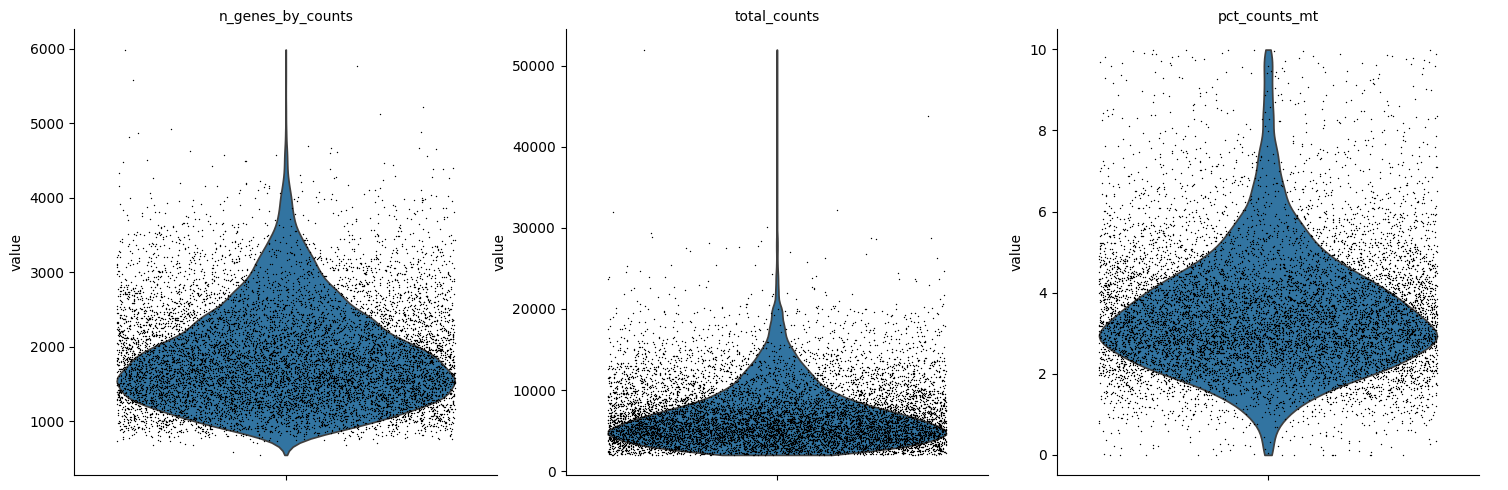

In [13]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [14]:
adata.obs['predicted_doublets'].value_counts()

predicted_doublets
False    10273
None        35
True         4
Name: count, dtype: int64

In [15]:
adata = adata[adata.obs['predicted_doublets'] == 'False'].copy()

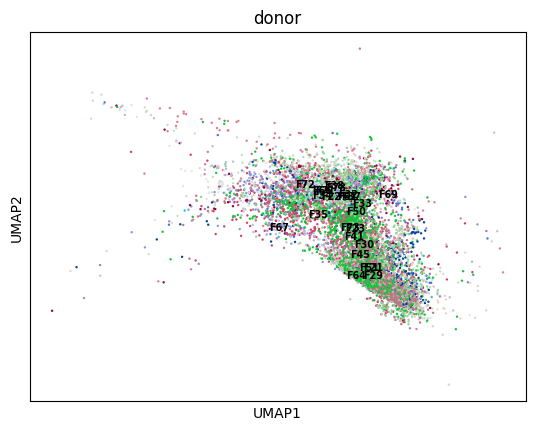

In [16]:
sc.pl.umap(adata,color='donor', legend_loc='on data', legend_fontsize='x-small')

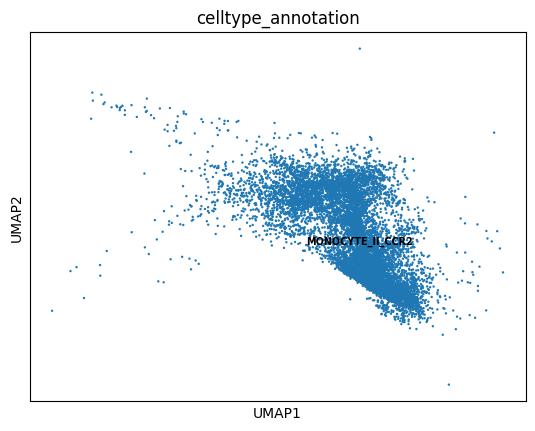

In [17]:
sc.pl.umap(adata,color='celltype_annotation', legend_loc='on data', legend_fontsize='x-small')

In [18]:
adata.obs['donor'].value_counts()

donor
F45    1647
F30    1444
F51    1230
F41    1199
F29    1069
F50    1058
F21     669
F38     402
F34     364
F71     261
F23     200
F61     189
F32     166
F35     155
F33      87
F22      41
F72      27
F73      15
F69      12
F37      12
F64       7
F67       7
F66       6
F78       6
Name: count, dtype: int64

In [21]:
# get top 4 donor IDs
top4_donors = adata.obs['donor'].value_counts().nlargest(4).index

# filter AnnData
adata_top4 = adata[adata.obs['donor'].isin(top4_donors)].copy()

In [23]:
print(adata_top4)

AnnData object with n_obs × n_vars = 5520 × 18156
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'leiden', 's

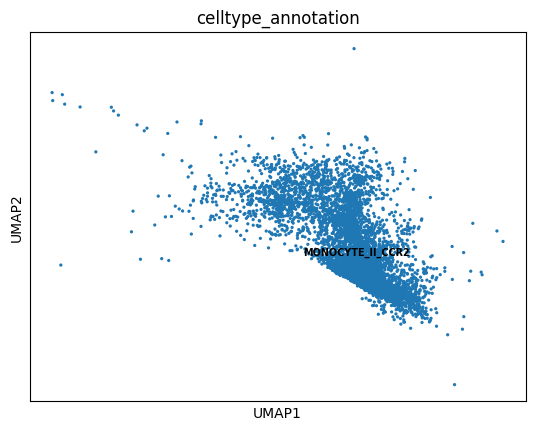

In [25]:
sc.pl.umap(adata_top4,color='celltype_annotation', legend_loc='on data', legend_fontsize='x-small')

In [30]:
adata_top4.obs['celltype_annotation'].value_counts()

celltype_annotation
MONOCYTE_II_CCR2    5520
Name: count, dtype: int64

In [26]:
#exporting extracted data
#exporting count data

# Convert to DataFrame with cells as rows, genes as columns
count_df = pd.DataFrame(
    adata_top4.X.toarray() if hasattr(adata_top4.X, "toarray") else adata_top4.X,
    index=adata_top4.obs_names,
    columns=adata_top4.var_names
)

In [28]:
# Save the DataFrame to a .tsv file
count_df.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/multi_benchmark/monocyte_top4/monocyte_top4_countdata.tsv", sep='\t')

In [29]:
#exporting metadata
# Save the observation metadata (cell-level annotations) as a CSV file
adata_top4.obs.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/multi_benchmark/monocyte_top4/monocyte_top4_metadata.csv")